1. Problem: What is the problem your paper addresses? Avoid describing the solution here.
Approximate bayesian computation uses simulators to help approximate the true posterior of a distribution when the likelihood is intractable.
2. Importance: How would a solution to this problem change the world? Remember that it’s not obvious to everyone else how important this problem is.
This allows bayesian inference to be done on a much wider class of models
3. Challenge: Why is this problem hard? and/or What difficulty do other solutions face?
Most traditional approaches use sampling methods, which are slow and thus do not handle expensive simulators well.
4. New capability: What can we do now that we couldn’t do before? Quantify if possible.
Our approach enables far fewer calls to the simulator
5. Background: A sentence or two about other approaches; yours or others.
Meeds and Welling use Gaussian Process and Hamiltonian Monte Carlo to speed up sampling methods, while Tran, Nott, and Kohn (2015) use variational inference by directly minimizing an approximation to the KL-divergence that introduces new variables.
6. Insight: What did you discover? or How did you approach the problem differently?
By using automatic differentiation, we can do variational inference by maximizing the lower bound without introducing new variables.
7. Solution: Provide some specific detail about the solution.
Our algorithm measures the standard deviation of the quantitative features in each dimension, then sorts the result, providing an optimal solution.
8. Evidence: Summarize the evidence you have for your approach: A proof, an implementation, or quantiative results.
Our algorithm achieves near-perfect performance on Bayesian linear regression, and substantially beats the performance of Trann, Nott, and Kohn on fitting an alpha-stable distribution.

Approximate bayesian computation uses simulators to help approximate the true posterior of a distribution when the likelihood is intractable.  This allows bayesian inference to be done on a much wider class of models.  Most traditional ABC approaches use sampling methods, which are slow and thus do not handle expensive simulators well.  Our approach enables far fewer calls to the simulator.  Meeds and Welling use Gaussian Process and Hamiltonian Monte Carlo to speed up sampling methods, while Tran, Nott, and Kohn (2015) use variational inference by directly minimizing an approximation to the KL-divergence that introduces new variables.  By using automatic differentiation, we can do variational inference by maximizing the lower bound without introducing new variables.  Our algorithm achieves near-perfect performance on Bayesian linear regression, and substantially outperforms Trann, Nott, and Kohn when fitting an alpha-stable distribution.

#Questions and Ideas
1.  Does the gradient estimator of KL have higher variance than the gradient estimator of lower bound?

Outline:<br/>
1.  Backround and Related Work<br/>
    a.  What is approximate bayesian computation? <br/>
    b.  Why is it important? <br/>
    c.  Why is it hard? <br/>
    d.  How have others tried to solve it? <br/>
2.  The model<br/>
    a.  decompose<br/>
    b.  Lower bound<br/>
    c.  reparametrization trick<br/>
    d.  KL divergence analytic form<br/>
    e.  single samples of $u$ and $\nu$<br/>
    f.  form of ABC kernel<br/>
    g.  final objective function<br/>
3.  Linear Regression<br/>
    a.  The global optimum is when $q(\theta)=p(\theta|X)$<br/>
        i.  when our recognition model has same parametric form as true posterior, parameters of global optimum are parameters of true posterior<br/>

b.  Bayesian linear regression:<br/>
4.  Wright Fisher<br/>

1.  Backround and Related Work<br/>
    a.  What is approximate bayesian computation, and why is it important? <br/>



    b.  Why is it important? <br/>
        1.  However, for many problems in science, particularly in domains such as population genetics, ecology, and astronomy, the likelihoods are either intractable or extremely expensive to compute.
    c.  Why is it hard? <br/>
        1.  Two basic methods: rejection sampling and metropolis hastings
        2.  Rejection sampling
            a.  If proposal distribution much "larger" than true posterior, very slow
            b.  does not work for high dimensional case
        3.  Metropolis Hastings 
            a.  solves high dimensional issue
            b.  long time to converge
            c.  can spend long periods in low probability regions
            d.  thus not good for expensive simulators
    d.  How have others tried to solve it? <br/>
        1.  Meeds and Welling (2014)
        2.  Meeds, Leenders, and Welling (2015)
        3.  Tran, Nott, and Kohn (2015)



#1.  Background and Related Work

Section Outline:
1.  Why is Bayesian inference important for science?
2.  What is Bayesian inference, and what are the problems?
3.  How is intractable Bayesian inference done today?  What is the problem with that (rejection sampling ineffective for high dimensions, MCMC slow for expensive simulators)?
4.  What are some solutions?
    a.  sampling-based (sequential monte carlo, gaussian process)
    b.  How did Tann, Nott, and Kohn do it?
5.  How do we propose to do it?

Parameter estimation and model selection are both important in a wide variety of scientific problems.  For parameter estimation, we may want to estimate evolutionary history based on genetic data, whether the market is in a boom or bust cycle, or what parameters were used to generate simulated data.  The latter is known as the inverse problem, and is an important problem in its own right.  For model selection, we have several models and we want to choose the model that best explains the observed data.  In many cases, having a distribution over parameter estimates is useful, as this gives information about the uncertainty of the estimate.  Thus, Bayesian methods are important to these classes of problems.

In Bayesian inference, one often wants to infer the posterior distribution $\pi(\theta|y)$ of some parameters or latent variables $\theta$, given observations $y$.

$$
\pi(\theta|y)=\frac{\pi(y|\theta)\pi(\theta)}{\int \pi(y|\theta)\pi(\theta)d\theta}
$$


where $\pi(y|\theta)$ is the likelihood, $\pi(\theta)$ is a prior on theta, and $\int \pi(y|\theta)\pi(\theta)d\theta=\pi(y)$ is the normalizing constant.  Often, the integral involved in calculating the normalizing constant is intractable, and alternatives such as sampling-based or variational methods are used.  Both sampling-based and variational methods assume knowledge of the likelihood.  However, for many problems in science, particularly in domains such as population genetics, ecology, and astronomy, the likelihoods are either intractable or extremely expensive to compute.  Fortunately, these fields often have simulators that allow synthetic data $x$ to be generated according to the parameters $\theta$, i.e. we can sample $x\sim \pi(x|\theta)$.  These are then compared to the true data via an $\epsilon$-kernel or ABC-kernel $K_{\epsilon}(y,x)$, which is an approximation to $\pi(y|x)$ and is a density that measures the disrepancy between x and y, where $\epsilon$ is the bandwith, and serves to control how close $x$ and $y$ should be to have a high acceptance probability.  The likelihood, $\pi(y|\theta)$, is approximated by $\pi_{\epsilon}(y|\theta)=\int K_{\epsilon}(y,x) \pi(x|\theta) \: dx$, and this approximation is exact, i.e. $\pi_{\epsilon}(y|\theta) = \pi (y|\theta)$ when $K_{\epsilon=0}(y,x)=\delta(y,x)$, where $\delta$ is the dirac-delta function.


##1.1 Sampling-based Methods

The two most popular ABC algorithms are the ABC rejection algorithm and a modified Metropolis Hastings algorithm.  In the ABC rejection algorithm, we first sample $\theta\sim\pi(\theta)$.  Next, sample $x\sim \pi(x|\theta)$.  Finally, accept $\theta$ with probability proportional to $K_\epsilon(y,x)$.  This approach has problems: if the bandwith $\epsilon$ is too small or if the data is high dimensional, it will spend most of the time rejecting samples.  If $\epsilon$ is too large, it will not give a good approximation and will be too heavily influenced by the prior.

A popular alternative is to use a modified Metropolis-Hastings as follows.  At every time $t$, we propose a move from $\theta$ to $\theta'$ by drawing $\theta'\sim q(\theta'|\theta)$.  We also sample $x'\sim \pi(x'|\theta)$.  Then we want to accept $\theta'$ with probability

$$
\alpha(\theta'|\theta) = \min\bigg(1, \frac{\pi_{\epsilon}(y|\theta') q(\theta',\theta)\pi(\theta')}{\pi_{\epsilon}(y|\theta) q(\theta, \theta')\pi(\theta)}\bigg)
$$

This scales well to high dimensions, but has the drawback that it requires the approximation $\pi_{\epsilon}(y|\theta) \approx \frac{1}{L}\sum_{l=1}^{L}K_{\epsilon}(y,x_{l}^{\theta})$, and thus requires $L$ calls to the simulator at each iteration.  For expensive simulators and with potentially slow mixing rates, this is impractical.

Recently, several techniques have been introduced to reduce the number of calls to the simualator.  Meeds and Welling developed sampling methods using Gaussian Processes (2014) and Hamiltonian Monte Carlo (2015), while Tran, Nott, and Kohn (2015) use variational inference, which in general converges much faster than sampling-based methods.

##1.2 Variational Inference

Variational Inference does approximate inference by minimizing the KL divergence between a recognition model, $q(\theta)$, and the true posterior, $\pi(\theta|y)$.  The KL divergence is a non-symmetric measure of the disrepancy between two distributions.  Doing this, $q(\theta)$ gives an approximation of $\pi(\theta|y)$.  This is often difficult to do directly, but we can decompose the log of the marginal probability into the KL divergence and a lower bound $\mathcal{L}$ as follows

$$\ln \pi(y) = KL(q(\theta) || \pi(\theta | y)) + \mathcal {L}$$

Where $\mathcal{L} = \int q(\theta) \ln \frac{\pi(y|\theta)\pi(\theta)}{q(\theta)} \:d\theta\\$.  Since the KL divergence may not be differentiable, variational inference usually involves maximizing the lower bound.  However, in the ABC case, doing so would require differentiating with respect to the approximate-likelihood, which would involve differentiating with respect to simulators, which may be very complex pieces of code.

Tran, Nott, and Kohn (2015) take an alternative approach in order to avoid maximizing the lower bound.  They first introduce a scalar $z=\log \hat{p}_{N}(x|\theta) - \log p(y|\theta)$, where  $\hat{p}_{N}(x|\theta)$ is an unbiased estimator of the true likelihood.  They then introduce the density $\pi_{N}(\theta,z)=\pi(\theta)e^{z}g_{N}(z|\theta)$, where $\pi(\theta)$ is the true posterior that we want to estimate, and $g_{N}(z|\theta)$ is the density of $z$.  They approximate $\pi_{N}(\theta,z)$ by $q_{\lambda,N}(\theta,z) = q_{\lambda}(\theta)g_{N}(z|\theta)$, where $q_{\lambda}(\theta)$ is the variational distribution with parameters $\lambda$ that approximates $\pi(\theta)$, the true posterior.  By introducing $z$, they work with $KL(q_{\lambda,N}(\theta,z) || \pi(\theta,z))$, which has a differentiable estimator, while $KL(q_{\lambda}(\theta)||\pi(\theta))$ may not.  They then show that under certain assumptions, the parameters $\lambda$ that minimize  $KL(q_{\lambda,N}(\theta,z) || \pi(\theta,z))$ also minimize $KL(q_{\lambda}(\theta)||\pi(\theta))$.  For the case of approximation bayesian compuation, they use the same approximate likelihood above, $\pi_{\epsilon}(y|\theta) \approx \frac{1}{L}\sum_{l=1}^{L}K_{\epsilon}(y,x_{l}^{\theta})$.

We also apply variational inference to the case of ABC.  However, unlike, Tran, Nott, and Kohn, we instead maximize the lower bound by using automatic differentiation to differentiate with respect to simulators.  This allows us to avoid introducing $z$ and approximating $\pi_{N}(\theta,z)$ by $q_{\lambda,N}(\theta,z)$.

What I think we want to show<br/>
1.  Is there some case where their assumptions don't hold?
2.  That we have some better theoretical property than their theorem 01
3.  Show that we beat them at fitting an alpha-stable distribution

#Approximate Bayesian Computation

In approximate bayesian computation (ABC), we want to estimate the posterior of a distribution in cases where the likelihood is intractable.  That is, we cannot compute $P(X|\theta)$ cirectly, where $X$ is our observed data and $\theta$ are some parameters, but we can generate synthetic data given some parameters via a simulator function $f(\theta,u)$, which takes as input $\theta$ and $u$, the latter being a randomness term for the simulator.  We want to use variational inference to approximate the posterior.  Variational inference is dependent on $P(X|\theta)$, but we want to rewrite the objective function so that it is dependent on $P(X|f(\theta,u))$.  In particular, we can rewrite the likelihood as follows.
$$
\begin{eqnarray}
P(X|\theta) &=& \int P(X|f(\theta,u))P(f(\theta,u)|\theta)df\\
&=& \int P(X|f(\theta,u))p(u)du\\
&=& \sum_{n=1}^{N}\int P(x_{n}|f(\theta,u))p(u)du\\
\end{eqnarray}
$$

We then choose a distribution for $P(x_{n}|f(\theta,u))= K_{\epsilon}(x_{n},f(\theta,u))$ as an acceptance kernel, to probabilistically accept or reject a datapoint.  For instance, if we choose $K_{\epsilon}(x_{n},f(\theta,u))=\mathcal{N}(f,\lambda^{-1})$, then
$$
P(X|\theta)\approx \sum_{n=1}^{N}\int \mathcal{N}(x_{n}| f(\theta,u),\lambda^{-1})p(u)du
$$

#The Model


1.  What is variational inference?
2.  Variational ABC
3.  High Variance Estimators and the Reparametrization Trick
5.  Sampling and gradient descent

##Variational Inference

The lower bound,  $\mathcal{L}$, which we maximize, is given by:

$$\begin{eqnarray}
\mathcal{L} &=& \int q(\theta) \ln \frac{\pi(\theta,y)}{q(\theta)} \:d\theta\\
&=& \int q(\theta)\ln \pi(y|\theta) \:d\theta - \int q(\theta) \ln \frac{\pi(\theta)}{q(\theta)} \:d\theta\\
\end{eqnarray}$$



For our problem, we first note that $x$ is dependent on two parameters: $\theta$, the parameter we want to estimate, and $u$, a randomness parameter for the simulator.  We can rewrite this in terms of $\pi(y|x)$ as follows

$$\begin{eqnarray}
\mathcal{L} &=& \int \int q(\theta) \ln \pi(y|x) p(u) \:du \:d\theta-KL(q(\theta) || \pi(\theta))\\
&=& \mathbb{E}_{\theta\sim q(\theta),u\sim\mathcal{N}(0,1)}(\ln p(y|x))-KL(q(\theta) || \pi(\theta))\\
\end{eqnarray}$$

##High Variance Estimators and Reparametrization

The usual monte carlo estimate of the gradient for the expectations is $\frac{1}{L_{\theta}L_{u}}\sum_{l_{\theta}=1}^{L_{\theta}}\sum_{l_{u}=1}^{L_{u}}ln\:p(X|f(\theta_{l_{\theta}},u_{l_{u}}))$.  This has very high variance and will lead to poor optimization results when using gradient descent.  However, 
but using the reparametrization trick of Kingma and Welling (2013), if we use a normal distribution for the recognition model $q(\theta)$, so that $\theta$~$\mathcal{N}(\mu,\sigma^{2})$, we can let $\theta=\mu+\sigma\cdot\nu$, where $\nu\sim\mathcal{N}(0,1)$



##Sampling, Gradient Descent, and Automatic Differentiation

$$\mathcal{L}= \mathbb{E}_{q(\nu)}(\mathbb{E}_{u}(\ln p(X|f(\mu+\sigma\cdot \nu,u))))-KL(q(\theta) || p(\theta))\\$$

If we set our prior to $\mathcal{N}(0,1)$, then the KL-divergence can be integrated analytically and has a closed form solution ($J$ is the number of dimensions)

$$\mathcal{L}= \mathbb{E}_{q(\nu)}(\mathbb{E}_{u}(\ln p(X|f(\mu+\sigma\cdot \nu,u))))+\frac{1}{2}\sum_{j=1}^{J}(1+2\log\:\sigma-\mu^{2}-\sigma^{2})\\$$

Further, we can approximate the expectations with respect to $u$ and $q(\nu)$ with single samples $u_{s}$ and $v_{l}$ for each expectation

$$\begin{eqnarray}\mathcal{L}&\approx& \ln p(X|f(\mu+\sigma\cdot \nu_l,u_s))+\frac{1}{2}\sum_{j=1}^{J}(1+2\log\:\sigma-\mu^{2}-\sigma^{2})\\
&=& \sum_{n=1}^{N}\ln p(x_{n}|f(\mu+\sigma\cdot \nu_l,u_s))+\frac{1}{2}\sum_{j=1}^{J}(1+2\log\:\sigma-\mu^{2}-\sigma^{2})\\
\end{eqnarray}\\$$

Now $\ln p(X|f(\mu+\sigma\cdot \nu_l,u_s))$ represents our ABC rejection probability, so if we set that to $\mathcal{N}(f,\lambda)$, we have

$$\mathcal{L}\approx -\sum_{n=1}^{N}(\log\:2\pi+\log\:\lambda)-\frac{1}{2}(y-f)^{T}(\frac{1}{\lambda^{2}})I(y-f)+\frac{1}{2}\sum_{j=1}^{J}(1+2\log\:\sigma-\mu^{2}-\sigma^{2})\\$$

We assume that $u$ gets multiplied by $R$ in the simulator, and that $R$~$log\mathcal{N}(\mu_{R},\sigma_{R}^{2})$.  We thus need to estimate $\mu,\sigma,\lambda,\mu_{R}$, and $\sigma_{R}$.  Since in order to take the relevant derivatives, we need to differentiate with respect to $f(\theta,u)$, we use automatic differentiation on the entire lower bound.

<h1>A Test Case: Bayesian Linear Regression</h1>

The global max of the lower bound is when the recognition model is equal to the true posterior, i.e. $q(\theta)=p(\theta|X)$.  To show this, first note that $\log\: p(X) \geq \mathcal{L}$.  Now, let $q(\theta)=p(\theta|X)$:

$$\begin{eqnarray} 
\mathcal{L} &=& \int q(\theta) \ln \frac{p(\theta,X)}{q(\theta)} \:d\theta\\
&=& \int q(\theta) \ln \frac{p(\theta|X)p(X)}{p(\theta|X)} \:d\theta\\
&=& \int q(\theta) \ln p(X) \:d\theta\\
&=& \ln p(X) \int q(\theta) \:d\theta\\
&=& \ln p(X)
\end{eqnarray}$$

If our recognition model $q_{\phi_{r}}(\theta)$ has a parametric form with parameters $\phi_{r}$, and our true posterior has the same parametric form, with parameters $\phi_{t}$, then the optimum will be when $\phi_{r}=\phi_{t}$

As a test case, we use bayesian linear regression, where the prior is standard normal.  We generate data points $X$~$U(a,b)$, use a fixed weight vector $w$, and let $$y=X\cdot w+\epsilon$$ where $\epsilon$~$\mathcal{N}(0,\sigma_{e}^{2})$

In the following, we use steepest descent to minimize the negative lower bound with respect to $\mu$ and $\sigma$.  We set $u=0$, and thus we should converge to the true posterior, as $\mathbb{E}_{q(\nu)}(\mathbb{E}_{u}(\ln p(X|f(\mu+\sigma\cdot \nu,u))))$ becomes $\mathbb{E}_{q(\theta)}(\ln p(X|\theta))$

http://rsif.royalsocietypublishing.org/content/6/31/187.short
http://bioinformatics.oxfordjournals.org/content/24/23/2713.short


In [1]:
%matplotlib inline
execfile("test.py")

SyntaxError: invalid syntax (lfvbae.py, line 75)

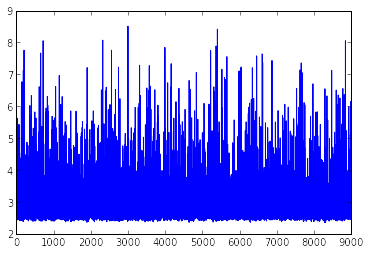

In [11]:
plot_cost(encoder,.85)

As we can see, 